#**Week16_복습과제_우정연**

##**9.5 콘텐츠 기반 필터링 실습 - TMDB 5000 영화 데이터 세트**

- 유명한 영화 데이터 정보 사이트인 IMDB의 영화 중 주요 5000개 영화에 대한 메타 정보를 새롭게 가공해 캐글에서 제공하는 데이터 세트
- 콘텐츠 기반 필터링 수행

###**[장르 속성을 이용한 영화 콘텐츠 기반 필터링]**
- 콘텐츠 기반 필터링: 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성 요소 등을 가진 다른 영화를 추천하는 것
  - 영화(또는 상품/서비스) 간의 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 평점, 키워드, 영화 설명)를 기반으로 하는 방식
- 영화 장르 속성을 기반으로 한 콘텐츠 기반 필터링 추천 시스템
  - 장르 칼럼 값의 유사도를 비교한 뒤 그중 높은 평점을 가지는 영화를 추천하는 방식

###**[데이터 로딩 및 가공]**

In [1]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')


movies = pd.read_csv('drive/My Drive/Colab Notebooks/data/archive/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

Mounted at /content/drive
(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [2]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity',
                    'keywords', 'overview']]

pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [3]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

movies_df['genres'] = movies_df['genres'].apply(lambda x : [y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


###**[장르 콘텐츠 유사도 측정]**
- genres 칼럼은 여러 개의 개별 장르가 리스트로 구성돼 있음
  - genres를 문자열로 변경한 뒤 이를 CountVectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교하는 방법
    1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
    2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교. 이를 위해 데이터 세트의 레코드 별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체를 생성
    3. 장르 유사도가 높은 영화 중 평점이 높은 순으로 영화 추천
    

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백 문자로 word 단위가 구분되는 문자열로 변환
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
count_vect = CountVectorizer(min_df = 0.0, ngram_range = (1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


- cosine_similarity(): 코사인 유사도 계산
  - 기준 행과 비교 행의 코사인 유사도를 행렬 형태로 반환하는 함수

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


- genre_sim 객체: movies_df의 genre_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행 별 유사도 정보를 가지고 있음.
  - movies_df DataFrame의 행별 장르 유사도 값을 가지고 있음
- movies_df의 개별 레코드에 대해 가장 장르 유사도가 높은 순으로 다른 레코드 추출
  - genre_sim 객체 이용

In [6]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


- 반환 값이 의미하는 것
  - 0번 레코드의 경우 자신인 0번 레코드를 제외하면 3494번 레코드가 가장 유사도가 높고, 그 다음이 813번, 가장 유사도가 낮은 레코드는 2401번 레코드

###**[장르 콘텐츠 필터링을 이용한 영화 추천]**
- find_sim_movie()
  - 장르 유사도에 따라 영화를 추천하는 함수

In [7]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_named를 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임
  # dataframe에서 index로 사용하기 위해 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [8]:
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


- 대부 2편이 가장 먼저 추천, 1847의 '좋은 친구들'도 비슷한 유형으로 추천
- 낯선 영화도 많음 -> 개선 필요!
- 더 많은 후보군을 선정한 뒤 영화의 평점에 따라 필터링 후 최종 추천하는 방식으로 변경
  - 'vote_average' 값 이용
    - 왜곡된 데이터를 가짐

In [9]:
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average',
                                                               ascending = False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


- 왜곡된 평점 데이터를 회피할 수 있도록 평점에 평가 횟수를 반영할 수 있는 새로운 평가 방식이 필요
- 유명한 영화 평점 사이트인 IMDB - 평가 횟수에 대한 가중치가 부여된 평점 방식을 사용
  - 가중 평점 공식
  - Weighted Rating = (v/(v+m)) * R + (m/(v+m)) * C
    - v: 개별 영화에 평점을 투표한 횟수
    - m: 평점을 부여하기 위한 최소 투표 횟수
    - R: 개별 영화에 대한 평균 평점
    - C: 전체 영화에 대한 평균 평점

In [10]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m,3))

C: 6.092 m: 370.2


In [11]:
percentile = 0.6
m = movies['vote_count'].quantile(percentile)
C = movies['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

movies['weighted_vote'] = movies.apply(weighted_vote_average, axis = 1)
movies_df = movies.copy()

movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending = False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


- 새롭게 정의된 평점 기준에 따라 영화 추천
  - 장르 유사성이 높은 영화를 top_n의 2배수만큼 후보군으로 선정한 뒤 weighted_vote 칼럼 값이 높은 순으로 top_n만큼 추출하는 방식으로 find_sim_movie() 함수 변경

In [12]:
def find_sim_movie(df, sorted_ind, title_name, top_n = 10):

  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending = False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]


,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427


##**9.6 아이템 기반 최근접 이웃 협업 필터링 실습**
- 최근접 이웃 협업 필터링
  - 사용자 기반
  - 아이템 기반: 추천 정확도가 일반적으로 더 뛰어남

###**[데이터 가공 및 변환]**

In [13]:
import pandas as pd
import numpy as np

movies = pd.read_csv('drive/My Drive/Colab Notebooks/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('drive/My Drive/Colab Notebooks/data/ml-latest-small/ratings.csv')
print(movies.shape)
print(ratings.shape)

(9742, 3)
(100836, 4)


- 협업 필터링: ratings.csv 데이터 세트와 같이 사용자와 아이템 간의 평점에 기반에 추천하는 시스템
- ratings.csv의 DataFrame인 ratings를 이용해 아이템 기반의 최근접 이웃 협업 필터링 구현
  - 로우(행) 레벨 형태의 원본 데이터 세트를 모든 사용자를 로우로, 모든 영화를 칼럼으로 구성한 데이터 세트로 변경
    - pivot_table() 함수 이용

In [14]:
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns = 'movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 사용자가 평점을 매기지 않은 영화가 칼럼으로 변환 -> NaN 값으로 할당
- NaN -> 0
- 칼럼명을 movieId가 아닌 영화명(title)으로 변경

In [15]:
# title 칼럼을 얻기 위해 movies와 조인
rating_movies = pd.merge(ratings, movies, on='movieId')

# columns='title'로 title 칼럼으로 피벗 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns='title')

# NaN 값을 모두 0으로 변환
ratings_matrix = ratings_matrix.fillna(0)
ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###**[영화 간 유사도 산출]**
- cosine_similarity() 이용
  - cosine_similarity() 함수는 행을 기준으로 서로 다른 행을 비교해 유사도를 산출
  - ratings_matrix는 userId가 기준인 행 레벨 데이터이므로 여기에 cosine_similarity()를 적용하면 영화 간의 유사도가 아닌 사용자 간의 유사도가 만들어짐
- 영화를 기준으로 cosine_similarity()를 적용하려면 현재의 ratings_matrix가 행 기준이 영화가 되고 열 기준이 사용자가 돼야 함
  - transpose() 함수를 이용해 ratings_matrix 데이터의 행과 열의 위치를 변경

In [16]:
ratings_matrix_T = ratings_matrix.transpose()
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
from sklearn.metrics.pairwise import cosine_similarity

item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity()로 반환된 넘파이 행렬을 영화명을 매핑해 DataFrame으로 변환
item_sim_df = pd.DataFrame(data = item_sim, index = ratings_matrix.columns,
                           columns = ratings_matrix.columns)

print(item_sim_df.shape)
item_sim_df.head(3)

(9719, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.141653,0.0,...,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.0,0.0,0.0,0.176777,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


In [18]:
item_sim_df["Godfather, The (1972)"].sort_values(ascending = False)[:6]

,"Godfather, The (1972)"
title,
"Godfather, The (1972)",1.000000
"Godfather: Part II, The (1974)",0.821773
Goodfellas (1990),0.664841
One Flew Over the Cuckoo's Nest (1975),0.620536
Star Wars: Episode IV - A New Hope (1977),0.595317
Fargo (1996),0.588614


In [19]:
item_sim_df["Inception (2010)"].sort_values(ascending = False)[1:6]

,Inception (2010)
title,
"Dark Knight, The (2008)",0.727263
Inglourious Basterds (2009),0.646103
Shutter Island (2010),0.617736
"Dark Knight Rises, The (2012)",0.617504
Fight Club (1999),0.615417


###**[아이템 기반 최근접 이웃 협업 필터링으로 개인화된 영화 추천]**
- 앞 예제: 사용자 평점을 기준으로 유사도 생성 -> 개인적인 취향을 반영하지 않고 영화 간 유사도만을 기준으로 추천한 것임
- 영화 유사도 데이터를 이용한 최근접 이웃 협업 필터링으로 개인에게 최적화된 영화 추천 구현
  - 가장 큰 특징: 개인이 아직 관람하지 않은 영화를 추천
  - 아직 관람하지 않은 영화에 대해 아이템 유사도와 기존 관람한 영화의 평점 데이터를 기반으로 새롭게 모든 영화의 예측 평점을 계산한 후 높은 예측 평점을 가진 영화를 추천하는 방식
  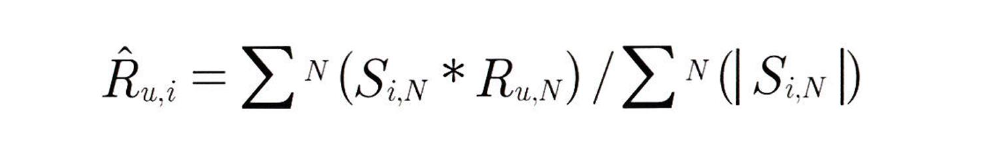
  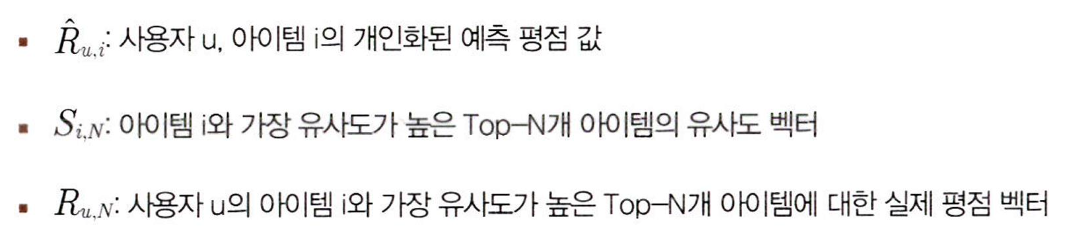

- Si,N와 Ru,N에 나오는 N의 값은 아이템의 최근접 이웃 범위 계수(item neighbor)를 의미
  - 특정 아이템과 유사도가 가장 높은 Top-N개의 다른 아이템을 추출하는 데 사용됨

In [20]:
def predict_rating(ratings_arr, item_sim_arr):
  ratings_pred = ratings_arr.dot(item_sim_arr)/np.array([np.abs(item_sim_arr).sum(axis = 1)])
  return ratings_pred
ratings_pred = predict_rating(ratings_matrix.values, item_sim_df.values)
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.070345,0.577855,0.321696,0.227055,0.206958,0.194615,0.249883,0.102542,0.157084,0.178197,...,0.113608,0.181738,0.133962,0.128574,0.006179,0.212070,0.192921,0.136024,0.292955,0.720347
2,0.018260,0.042744,0.018861,0.000000,0.000000,0.035995,0.013413,0.002314,0.032213,0.014863,...,0.015640,0.020855,0.020119,0.015745,0.049983,0.014876,0.021616,0.024528,0.017563,0.000000
3,0.011884,0.030279,0.064437,0.003762,0.003749,0.002722,0.014625,0.002085,0.005666,0.006272,...,0.006923,0.011665,0.011800,0.012225,0.000000,0.008194,0.007017,0.009229,0.010420,0.084501


- 예측 평점이 사용자별 영화의 실제 평점과 영화의 코사인 유사도를 내적한 값이기에 기존에 영황를 관람하지 않아 0에 해당했던 실제 영화 평점이 예측에서는 값이 부여되는 경우가 많이 발생
- 예측 평점이 실제 평점에 비해 작을 수 있음
  - 내적 결과를 코사인 유사도 벡터 합으로 나누었기 때문에 생기는 현상
- 원래의 실제 평점과 얼마나 차이가 있는지 확인
  - 예측 평가 지표 MSE 적용
    - 사용자가 영화의 평점을 주지 않은 경우: 앞에서는 평점을 0으로 부과 / but 개인화된 예측 점수는 평점을 주지 않은 영화에 대해서도 아이템 유사도에 기반해 평점을 예측
    - 실제와 예측 평점의 차이는 기존에 평점이 부여된 데이터에 대해서만 오차 정도를 측정

In [21]:
from sklearn.metrics import mean_squared_error

# 사용자가 평점을 부여한 영화에 대해서만 예측 성능 평가 MSE를 구함
def get_mse(pred, actual):
  # 평점이 있는 실제 영화만 추출
  pred = pred[actual.nonzero()].flatten()
  actual = actual[actual.nonzero()].flatten()
  return mean_squared_error(pred, actual)

print('아이템 기반 모든 최근접 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

아이템 기반 모든 최근접 이웃 MSE:  9.895354759094706


- 실제 값과 예측 값은 서로 스케일이 다르므로 MSE가 클 수도 있음
- 중요한 것은 MSE를 감소시키는 방향으로 개선하는 것
- predict_rating() 함수: 해당 영화와 다른 모든 영화 간의 유사도 벡터를 적용한 것
  - 특정 영화와 가장 비슷한 유사도를 가지는 영화에 대해서만 유사도 벡터를 적용하는 함수로 변경 predict_rating_topsim(rating_arr, item_sim_arr, n = 20)

In [22]:
def predict_rating_topsim(ratings_arr, item_sim_arr, n=20):
    # 사용자-아이템 평점 행렬 크기만큼 0으로 채운 예측 행렬 초기화
    pred = np.zeros(ratings_arr.shape)

    # 사용자-아이템 평점 행렬의 열 크기만큼 루프 수행
    for col in range(ratings_arr.shape[1]):
        # 유사도 행렬에서 유사도가 큰 순으로 n개 데이터 행렬의 인덱스 반환
        top_n_items = np.argsort(item_sim_arr[:, col])[:-n-1:-1]

        # 개인화된 예측 평점을 계산
        for row in range(ratings_arr.shape[0]):
            # top_n_items의 유사도와 평점을 곱하여 예측 평점 계산
            pred[row, col] = item_sim_arr[col, top_n_items].dot(ratings_arr[row, top_n_items].T)
            pred[row, col] /= np.sum(np.abs(item_sim_arr[col, top_n_items]))

    return pred

# 예측 평점 행렬 계산
ratings_pred = predict_rating_topsim(ratings_matrix.values, item_sim_df.values, n=20)

# MSE 계산 (get_mse 함수는 별도로 정의되어 있어야 합니다)
print('아이템 기반 최근접 TOP-20 이웃 MSE: ', get_mse(ratings_pred, ratings_matrix.values))

# 계산된 예측 평점 데이터를 DataFrame으로 변환
ratings_pred_matrix = pd.DataFrame(data=ratings_pred, index=ratings_matrix.index, columns=ratings_matrix.columns)


아이템 기반 최근접 TOP-20 이웃 MSE:  3.6949827608772314


- MSE 향상됨
- 특정 사용자에 대해 영화 추천

In [23]:
user_rating_id = ratings_matrix.loc[9, :]
user_rating_id[user_rating_id > 0].sort_values(ascending = False)[:10]

,9
title,
Adaptation (2002),5.0
Citizen Kane (1941),5.0
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),5.0
"Producers, The (1968)",5.0
"Lord of the Rings: The Two Towers, The (2002)",5.0
"Lord of the Rings: The Fellowship of the Ring, The (2001)",5.0
Back to the Future (1985),5.0
Austin Powers in Goldmember (2002),5.0
Minority Report (2002),4.0


- 사용자에게 아이템 기반 협업 필터링을 통해 영화 추천
  - get_unseen_movies(): 먼저 사용자가 이미 평점을 준 영화를 제외하고 추천할 수 있도록 평점을 주지 않은 영화를 리스트 객체로 반환하는 함수

In [24]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듬
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듬
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

In [25]:
def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬함
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies

# 사용자가 관람하지 않는 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 아이템 기반의 최근접 이웃 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n=10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data = recomm_movies.values, index = recomm_movies.index,
                             columns = ['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


##**9.7 행렬 분해를 이용한 잠재 요인 협업 필터링 실습**
- 행렬 분해를 이용한 잠재 요인 협업 필터링 구현
- 행렬 분해 잠재 요인 협업 필터링
  - SVD 나 NMF 등을 적용 가능
  - 일반적으로 행렬 분해에는 SVD가 자주 사용되지만 사용자-아이템 평점 행렬에는 사용자가 평점을 매기지 않은 null 데이터가 많아 주로 SGD나 ALS 기반 행렬분해를 이용
  - 본 예제: SGD 기반의 행렬 분해를 구현하고 이를 기반으로 사용자에게 영화 추천
    - 확률적 경사 하강법을 이용

In [26]:
def matrix_factorization(R, K, steps = 100, learning_rate = 0.01, r_lambda = 0.01):
  num_users, num_items = R.shape
  # P와 Q 매트릭스의 크기를 지정하고 정규 분포를 가진 랜덤 값으로 입력
  np.random.seed(1)
  P = np.random.normal(scale = 1./K, size = (num_users, K))
  Q = np.random.normal(scale = 1./K, size = (num_items, K))

  prev_rmse = 10000
  break_count = 0

  # R > 0인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장
  non_zeros = [ (i, j, R[i, j]) for i in range(num_users) for j in range(num_items) if R[i,j]>0 ]

  # SGD 기법으로 P와 Q 매트릭스를 계속 업데이트
  for step in range(steps):
    for i, j, r in non_zeros:
      # 실제 값과 예측 값의 차이인 오류값 구함
      eij = r - np.dot(P[i, :], Q[j, :].T)
      # Regularization을 반영한 SGD 업데이트 공식 적용
      P[i, :] = P[i, :] + learning_rate * (eij * Q[j, :] - r_lambda * P[i, :])
      Q[j, :] = Q[j, :] + learning_rate * (eij * P[i, :] - r_lambda * Q[j, :])

      rmse = get_rmse(R, P, Q, non_zeros)
      if (step % 10) == 0:
        print('### iteration step: ', step, " rmse: ", rmse)

  return P,Q

In [27]:
from sklearn.metrics import mean_squared_error

def get_rmse(R, P, Q, non_zeros):
  error = 0
  # 두 개의 분해된 행렬 P와 Q.T의 내적으로 예측 R 행렬 생성
  full_pred_matrix = np.dot(P, Q.T)

  # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출해 실제 R 행렬과 예측 행렬의 RMSE 추출
  x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
  y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
  R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
  full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
  mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
  rmse = np.sqrt(mse)

  return rmse

- matrix_factorization() 함수를 이용해 행렬 분해

In [28]:
movies = pd.read_csv('drive/My Drive/Colab Notebooks/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('drive/My Drive/Colab Notebooks/data/ml-latest-small/ratings.csv')
ratings = ratings[['userId', 'movieId', 'rating']]
ratings_matrix = ratings.pivot_table('rating', index = 'userId', columns = 'movieId')

# title 칼럼을 얻기 위해 movies와 조인 수행
rating_movies = pd.merge(ratings, movies, on='movieId')
# columns = 'title' 로 title 칼럼으로 pivot 수행
ratings_matrix = rating_movies.pivot_table('rating', index = 'userId', columns = 'title')

P, Q = matrix_factorization(ratings_matrix.values, K = 50, steps = 100, learning_rate = 0.01,
                            r_lambda = 0.01)
pred_matrix = np.dot(P, Q.T)

Streaming output truncated to the last 5000 lines.
### iteration step:  0  rmse:  2.9871688379972077
### iteration step:  0  rmse:  2.9871760812162016
### iteration step:  0  rmse:  2.9871787637561815
### iteration step:  0  rmse:  2.987172927868749
### iteration step:  0  rmse:  2.9871638181056
### iteration step:  0  rmse:  2.9871533877060092
### iteration step:  0  rmse:  2.9871364458206915
### iteration step:  0  rmse:  2.9871276085318113
### iteration step:  0  rmse:  2.9871152866051305
### iteration step:  0  rmse:  2.9871079832796754
### iteration step:  0  rmse:  2.987101605807159
### iteration step:  0  rmse:  2.987115238204058
### iteration step:  0  rmse:  2.98712239967821
### iteration step:  0  rmse:  2.987113735366527
### iteration step:  0  rmse:  2.987115906773373
### iteration step:  0  rmse:  2.9871139358387873
### iteration step:  0  rmse:  2.9870970514071877
### iteration step:  0  rmse:  2.987084826829029
### iteration step:  0  rmse:  2.987086582265424
### iterati

KeyboardInterrupt: 

- 시간이 너무 오래 걸려서 포기했어요..


In [31]:
ratings_pred_matrix = pd.DataFrame(data = pred_matrix, index = ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_pred_matrix.head(3)

NameError: name 'pred_matrix' is not defined

- 예측 사용자-아이템 평점 행렬 정보를 이용해 개인화된 영화 추천

In [30]:
def get_unseen_movies(ratings_matrix, userId):
  # userId로 입력받은 사용자의 모든 영화 정보를 추출해 Series로 반환함
  # 반환된 user_rating은 영화명(title)을 인덱스로 가지는 Series 객체임
  user_rating = ratings_matrix.loc[userId, :]

  # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 인덱스를 추출해 list 객체로 만듬
  already_seen = user_rating[user_rating > 0].index.tolist()

  # 모든 영화명을 list 객체로 만듬
  movies_list = ratings_matrix.columns.tolist()

  # list comprehension으로 already_seen에 해당하는 영화는 movies_list에서 제외함
  unseen_list = [movie for movie in movies_list if movie not in already_seen]

  return unseen_list

def recomm_movie_by_userid(pred_df, userId, unseen_list, top_n = 10):
  # 예측 평점 DataFrame에서 사용자 id 인덱스와 unseen_list로 들어온 영화명 칼럼을 추출해
  # 가장 예측 평점이 높은 순으로 정렬함
  recomm_movies = pred_df.loc[userId, unseen_list].sort_values(ascending = False)[:top_n]
  return recomm_movies


In [29]:
# 사용자가 관람하지 않은 영화명 추출
unseen_list = get_unseen_movies(ratings_matrix, 9)

# 잠재 요인 협업 필터링으로 영화 추천
recomm_movies = recomm_movie_by_userid(ratings_pred_matrix, 9, unseen_list, top_n = 10)

# 평점 데이터를 DataFrame으로 생성
recomm_movies = pd.DataFrame(data=recomm_movies.values, index = recomm_movies.index,
                             columns = ['pred_score'])
recomm_movies

,pred_score
title,
Shrek (2001),0.866202
Spider-Man (2002),0.857854
"Last Samurai, The (2003)",0.817473
Indiana Jones and the Temple of Doom (1984),0.816626
"Matrix Reloaded, The (2003)",0.800990
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001),0.765159
Gladiator (2000),0.740956
"Matrix, The (1999)",0.732693
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.689591


- 앞 절의 아이템 기반 협업 필터링 결과와는 추천 영화가 많이 다름